In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import psycopg2

%matplotlib inline
sns.set_context('talk')

In [2]:
conn = psycopg2.connect("dbname='scrapegame' user='rickwolf' password='mypass'")
cur = conn.cursor()

review_id
game_id
reviewer
text
date
score

In [44]:
query = """
SELECT reviewer, COUNT(*) AS num_reviews, MIN(date) AS earliest_review, 
    AVG(score) AS avg_score
FROM reviews
GROUP BY reviewer
"""

cur.execute(query)

In [46]:
df = pd.DataFrame(cur.fetchall(), columns=['username', 'num_reviews', 'earliest_review', 'avg_score'])
df['avg_score'] = df['avg_score'].astype(float)
df.head()

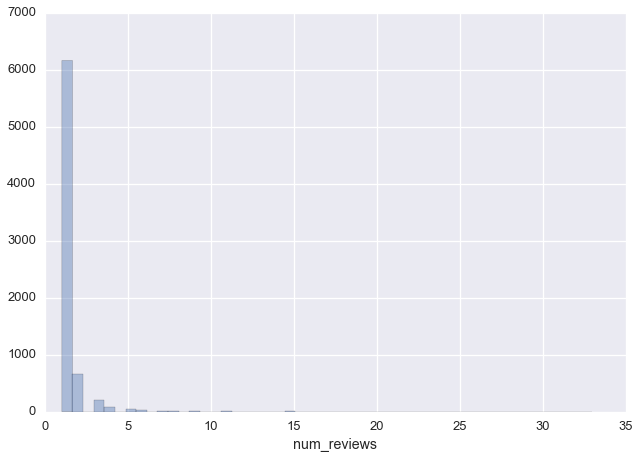

In [13]:
sns.distplot(df.num_reviews, kde=False)
sns.despine()

In [56]:
df.describe()

,num_reviews,avg_score
count,7260.000000,7260.000000
mean,1.320110,6.300585
std,1.264566,3.689441
min,1.000000,0.000000
25%,1.000000,3.000000
50%,1.000000,8.000000
75%,1.000000,10.000000
max,33.000000,10.000000


In [51]:
df.num_reviews.quantile(.97)

4.0

85% of users only write one review, but some write as many as 33

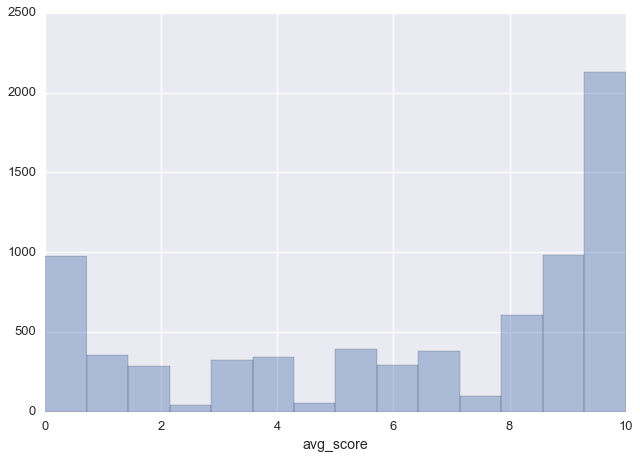

In [57]:
sns.distplot(df.avg_score, kde=False)

distribution is slightly bimodal towards the extremes of ratings.

/Users/rickwolf/anaconda/envs/my_projects_env/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


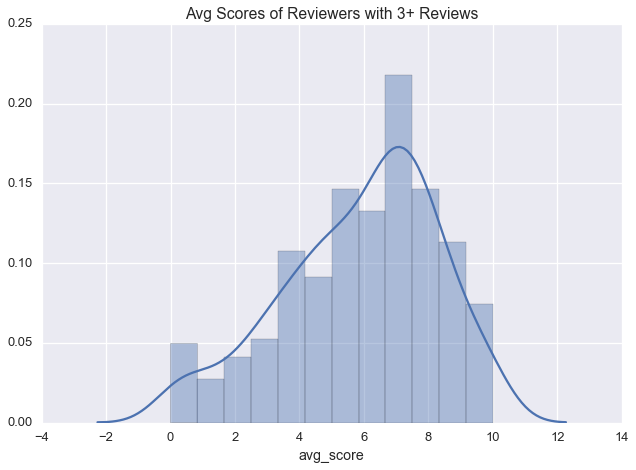

In [60]:
sns.distplot(df.loc[df['num_reviews'] > 2, 'avg_score'])
sns.plt.title("Avg Scores of Reviewers with 3+ Reviews")

/Users/rickwolf/anaconda/envs/my_projects_env/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


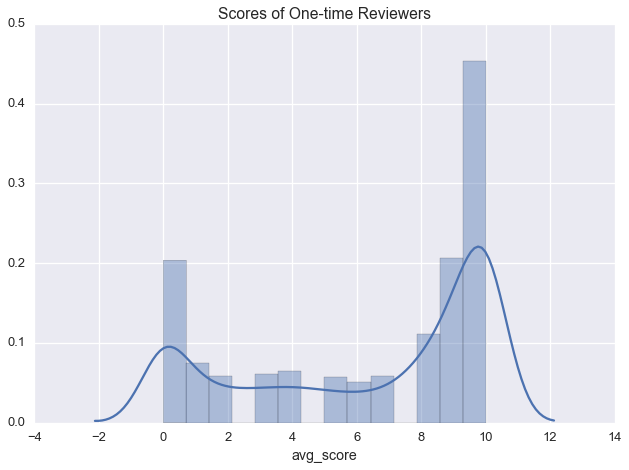

In [61]:
sns.distplot(df.loc[df['num_reviews'] == 1, 'avg_score'])
sns.plt.title('Scores of One-time Reviewers')

In [77]:
# Generate a histogram of review scores for scores in reviews made by a repeat reviewer
query = """
SELECT review_id, a.reviewer, score
FROM reviews AS a
LEFT JOIN (
    SELECT reviewer, COUNT(*) AS num_reviews
    FROM reviews
    GROUP BY reviewer
) AS b
ON a.reviewer = b.reviewer
WHERE num_reviews > 1
"""

cur.execute(query)
multi_revs = pd.DataFrame(cur.fetchall(), columns=['review_id', 'reviewer', 'rev_score'])
len(multi_revs)

/Users/rickwolf/anaconda/envs/my_projects_env/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


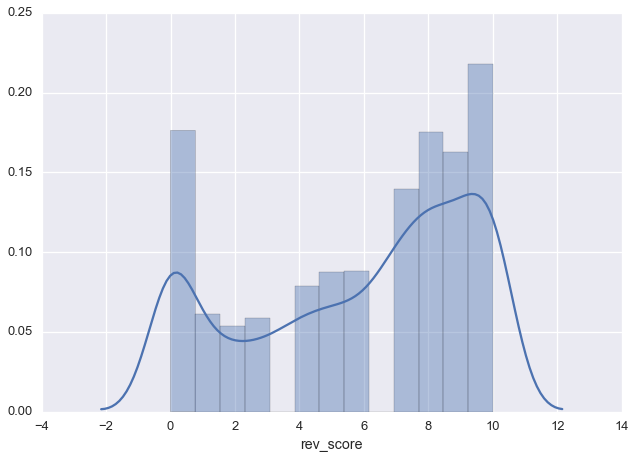

In [82]:
sns.distplot(multi_revs['rev_score'])

# Look at word count per review

In [3]:
query = """
SELECT a.game_id, b.gametitle, a.reviewer, a.text, a.score, a.date
FROM reviews AS a JOIN games AS b ON a.game_id = b.gameid
"""

cur.execute(query)
df = pd.DataFrame(cur.fetchall(), columns=['gameid', 'title', 'reviewer', 'text', 'score', 'date'])

In [24]:
# generate word count of each review
df['wc'] = df.text.apply(lambda x: len(x.split()))
df['sc'] = df.text.apply(lambda x: len(x.split('.')))

/Users/rickwolf/anaconda/envs/my_projects_env/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


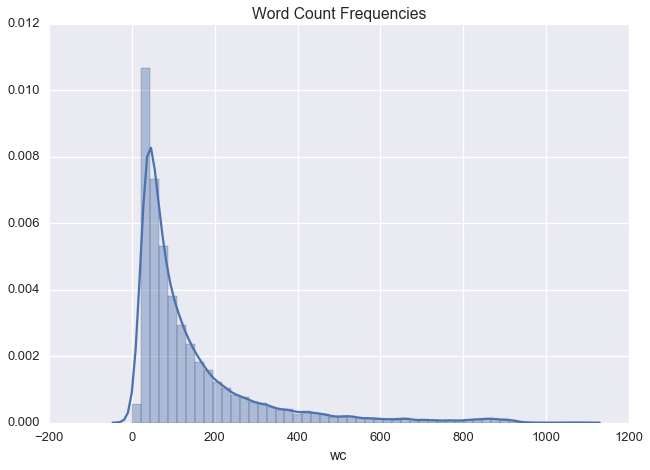

In [18]:
sns.distplot(df['wc'])
sns.plt.title('Word Count Frequencies')

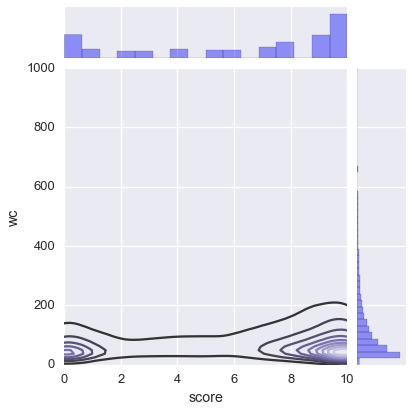

In [34]:
g = sns.JointGrid(x='score', y='wc', data=df, xlim = (0, 10), ylim = (0, 1000))
g = g.plot_joint(sns.kdeplot, cmap="Purples_d")
g = g.plot_marginals(sns.distplot, kde=False, color='b')